# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.  
Построим модель, которая по фотографии определит приблизительный возраст человека.  
В нашем распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта ChaLearn Looking at People. В папке /datasets/faces/ имеется одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: `file_name` и `real_age`.

In [1]:
# Импортируем необходимые библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

## Исследовательский анализ данных

In [2]:
# Загрузим датасет
path = '/datasets/faces'
df = pd.read_csv(path+'/labels.csv')

In [3]:
# Посмотрим размер выборки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет содержит 7591 фотографию, этого достаточно, чтоб обучить и проверить модель. Для обучающей выборки будем брать 0,8 датасета, для тестирования - 0,2.

In [4]:
# Посмотрим первые строки
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Посмотрим статистики по возрастам
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

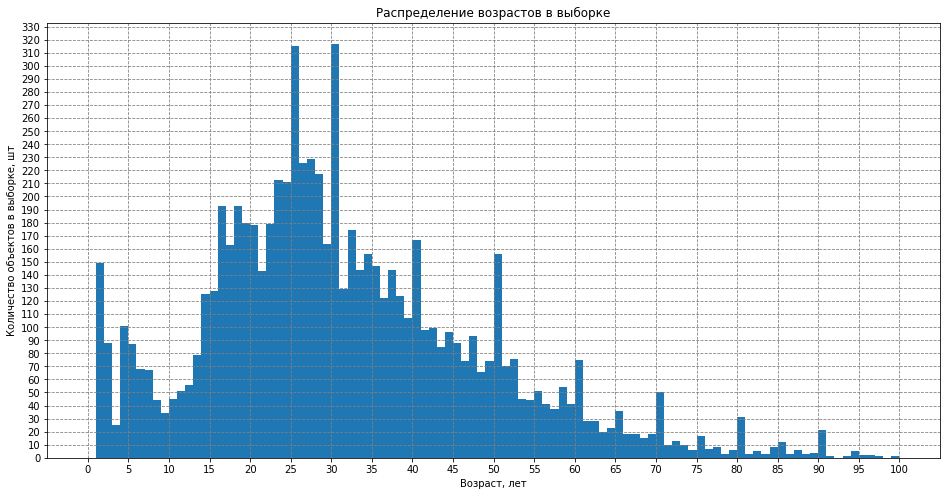

In [6]:
# Посмотрим распределение возрастов
fig = plt.figure(figsize=(16,8))
plt.title('Распределение возрастов в выборке')
plt.grid(color='grey', linestyle='--')
plt.xlabel('Возраст, лет')
plt.xticks(range(0,101,5))
plt.ylabel('Количество объектов в выборке, шт')
plt.yticks(range(0,351,10))
plt.hist(df['real_age'], bins=range(0,101,1))
plt.show()

Как видим, в основном представлены фото людей в возрасте 15-45 лет, при этом в выборке представлены фото людей широкого диапазона возрастов: от 1 до 100 лет. При этом видны всплески количества фото в юбилейные годы, что может свидетельствовать о не очень качественной разметке части данных.

In [7]:
# Загрузим одно изображение и проверим его размер
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_directory(directory=path+'/final_files',
                                           batch_size=1)
features, target = next(datagen_flow)

# Проверим размер изображений и количество каналов
features.shape

Found 0 images belonging to 0 classes.


(0, 256, 256, 3)

Found 7591 validated image filenames.


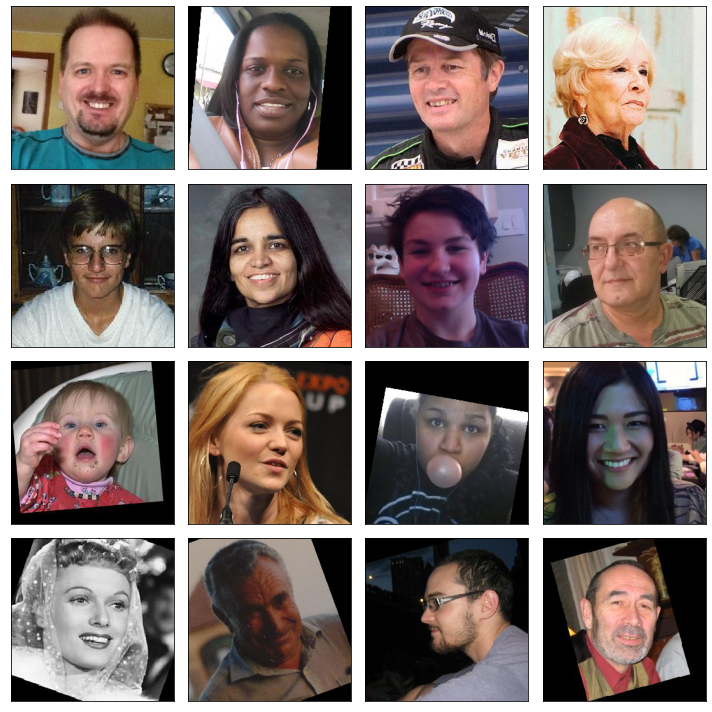

In [8]:
# Создадим загрузчик
datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                           directory=path+'/final_files',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(256, 256),
                                           color_mode='rgb',
                                           class_mode='raw',
                                           batch_size=16,
                                           seed=12345)                                          
# Загрузим и выведем 16 изображений
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

При рассмотрении фото можем увидеть: имеются черно-белые фотографии, посторонние предметы, преобразования, которым были подвергнуты фото (сдвиги, повороты), есть лица крупным планом. Исходя из особенностей фото добавим в настройках загрузчика, который будет использоваться для обучения модели, параметры аугментации rotation_range до 30 градусов, width_shift_range до 0.2 и height_shift_range до 0.2.

## Обучение модели

Код обучения модели и её результат вывода на экран.
(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255.,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)
    train, test = train_test_split(pd.read_csv(path+'/labels.csv'), test_size=0.2, random_state=5)
    datagen_flow = datagen.flow_from_dataframe(dataframe=train,
                                               directory=path+'/final_files',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               class_mode='raw',
                                               batch_size=32,
                                               seed=12345)                                              
    return datagen_flow
    
def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255.)
    train, test = train_test_split(pd.read_csv(path+'/labels.csv'), test_size=0.2, random_state=5)
    datagen_flow = datagen.flow_from_dataframe(dataframe=test,
                                               directory=path+'/final_files',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               class_mode='raw',
                                               batch_size=32,
                                               seed=12345)                                              
    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', #'imagenet' 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate = 0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Found 6072 validated image filenames.
Found 1519 validated image filenames.
Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 131s - loss: 198.5336 - mean_absolute_error: 10.3836 - val_loss: 515.9787 - val_mean_absolute_error: 17.0525
Epoch 2/5
190/190 - 120s - loss: 91.2295 - mean_absolute_error: 7.2715 - val_loss: 451.4523 - val_mean_absolute_error: 15.7095
Epoch 3/5
190/190 - 120s - loss: 71.3316 - mean_absolute_error: 6.4239 - val_loss: 319.7024 - val_mean_absolute_error: 12.7047
Epoch 4/5
190/190 - 122s - loss: 53.0351 - mean_absolute_error: 5.5633 - val_loss: 175.3136 - val_mean_absolute_error: 9.4083
Epoch 5/5
190/190 - 120s - loss: 44.4724 - mean_absolute_error: 5.0889 - val_loss: 100.9053 - val_mean_absolute_error: 7.6404
48/48 - 8s - loss: 100.9053 - mean_absolute_error: 7.6404
Test MAE: 7.6404
```

## Анализ обученной модели

В ходе работы была создана модель, состоящая из:
- основы модели ResNet50,
- дополнительного полносвязного слоя с 512 нейронами с функцией активации ReLU,
- выходного нейрона с функцией активации ReLU.  
Обучение модели проводилось на тренировочной выборке, которая составила 80% от имеющейся выборки, с применением аугментации: поворот изображения в пределах 30 градусов, сдвиг по вертикали и по горизонтали до 20% от высоты и ширины изображения.  
Полученная модель позволила добиться метрики MAE 7,6404 на тестовой выборке.